In [75]:
import sys
sys.path.append('./evaluate')
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import torchvision
from mae_utils import *
import PIL
import requests
from io import BytesIO
from PIL import Image

    


## Load model

In [67]:
ckpt = 'path/to/checkpoint-3500.pth'
model = prepare_model(ckpt, arch='mae_vit_large_patch16')

model.eval()
model = model.to('cuda')

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Missing VQGAN keys: []
<All keys matched successfully>


## Setup utils and preprocessing

In [68]:

# A generalized imshow helper function which supports displaying (CxHxW) tensor
def generalized_imshow(arr):
    if isinstance(arr, torch.Tensor) and arr.shape[0] == 3:
        arr = arr.permute(1, 2, 0)
    plt.imshow(arr)
    plt.show()
    
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def create_grid_from_images(support_img, support_mask, query_img, query_mask, padding=1):
    canvas = torch.zeros((support_img.shape[0], 2 * support_img.shape[1] + 2 * padding,
                         2 * support_img.shape[2] + 2 * padding))
    canvas[:, :support_img.shape[1], :support_img.shape[2]] = support_img
    canvas[:, -query_img.shape[1]:, :query_img.shape[2]] = query_img
    canvas[:, :support_img.shape[1], -support_img.shape[2]:] = support_mask
    canvas[:, -query_img.shape[1]:, -support_img.shape[2]:] = query_mask

    return canvas

import torchvision
padding = 1
image_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((224 // 2 - padding, 224 // 2 - padding)),
     torchvision.transforms.ToTensor()])

single_image_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((224, 224)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


# Different functions to construct visual prompts

In [69]:
import requests
from io import BytesIO
from PIL import Image


def url_to_pil(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def run_model(source, target, new_source):
    source = url_to_pil(source).convert('RGB')
    target = url_to_pil(target).convert('RGB')
    new_source =  url_to_pil(new_source).convert('RGB')

    source = image_transform(source)
    target = image_transform(target)
    new_source = image_transform(new_source)
    grid = create_grid_from_images(source, target, new_source, new_source)
    grid = (grid - imagenet_mean[:,None,None]) / imagenet_std[:, None,None]
    grid = grid[np.newaxis, :, :, :]
    ids_shuffle, len_keep = generate_mask_for_evaluation()
    grid = grid.to('cuda')
    orig_image, im_paste, mask = generate_image(grid, model, ids_shuffle.to('cuda'), len_keep, device='cuda')
    plt.figure(figsize=(8, 6), dpi=80)
    return PIL.Image.fromarray(np.uint8(np.clip(im_paste.detach().cpu().numpy(), 0, 255)))
    
# load image, occlude bottom right part and predict the completion
def run_model_single_img(img):
    img = url_to_pil(img).convert('RGB')
    img = single_image_transform(img)
    grid = img[np.newaxis, :, :, :]
    
    
    ids_shuffle, len_keep = generate_mask_for_evaluation()
    grid = grid.to('cuda')
    orig_image, im_paste, mask = generate_image(grid, model, ids_shuffle.to('cuda'), len_keep, device='cuda')
    plt.figure(figsize=(8, 6), dpi=80)
    return PIL.Image.fromarray(np.uint8(np.clip(im_paste.detach().cpu().numpy(), 0, 255)))

def run_model_with_variable_placements(source, target, new_source):
    source_p = url_to_pil(source).convert('RGB')
    im = PIL.Image.new(mode="RGB", size=(512, 512), color='white')
    im.paste(source_p.resize((256,256)), (0, 0, 256, 256))
    source = im

    target_p = url_to_pil(target).convert('RGB')
    im = PIL.Image.new(mode="RGB", size=(512, 512), color='white')
    im.paste(target_p.resize((256, 256)), (128, 128, 384, 384))
    target = im

    new_source_p =  url_to_pil(new_source).convert('RGB')
    im = PIL.Image.new(mode="RGB", size=(512, 512), color='white')
    im.paste(new_source_p.resize((256,256)), (0, 0, 256, 256))
    new_source = im

    source = image_transform(source)
    target = image_transform(target)
    new_source = image_transform(new_source)
    grid = create_grid_from_images(source, target, new_source, new_source)
    grid = (grid - imagenet_mean[:,None,None]) / imagenet_std[:, None,None]
    grid = grid[np.newaxis, :, :, :]
    ids_shuffle, len_keep = generate_mask_for_evaluation()
    grid = grid.to('cuda')
    orig_image, im_paste, mask = generate_image(grid, model, ids_shuffle.to('cuda'), len_keep, device='cuda')
    plt.figure(figsize=(8, 6), dpi=80)
    return PIL.Image.fromarray(np.uint8(np.clip(im_paste.detach().cpu().numpy(), 0, 255)))


# Run model on internet images, manully construct the visual prompt

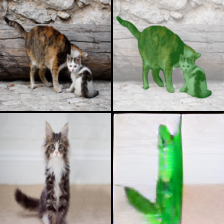

In [70]:
source = "https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2022/06/14/ML-8362-image001-300.jpg"
target ="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2022/06/14/ML-8362-image003-300.png"
new_source = "https://static.scientificamerican.com/sciam/cache/file/1E3A3E62-B3CA-434A-8C3B3ED0C982FB69_source.jpg?w=590&h=800&C8DB8C57-989B-4118-AE27EF1191E878A5"
run_model(source, target, new_source)

# Segmentation, colorization, style transfer examples

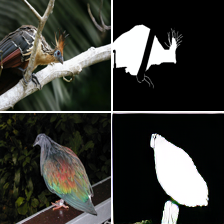

In [71]:
run_model_single_img('https://yossigandelsman.github.io/visual_prompt/sup/assets/segmentation/0_31_BEIT.png')

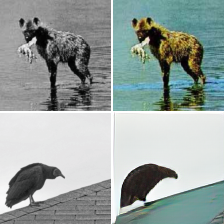

In [72]:
run_model_single_img('https://yossigandelsman.github.io/visual_prompt/sup/assets/colorization/1177.png')

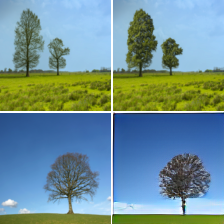

In [73]:
run_model_single_img("https://yossigandelsman.github.io/visual_prompt/sup/assets/other/tree.png")

# Run model on internet images. Shifted apple, this is an example failure case of the model

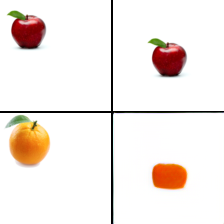

In [74]:
import requests
from io import BytesIO
from PIL import Image
source = "https://st2.depositphotos.com/7036298/10694/i/450/depositphotos_106948346-stock-photo-ripe-red-apple-with-green.jpg"
target ="https://st2.depositphotos.com/7036298/10694/i/450/depositphotos_106948346-stock-photo-ripe-red-apple-with-green.jpg"
new_source = "https://www.quanta.org/orange/orange.jpg"
run_model_with_variable_placements(source, target, new_source)